In [193]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import sklearn
from matplotlib import pyplot as plt
import regex
import statsmodels.api as sm
from itertools import combinations
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import random
import pickle

In [194]:
df=pd.read_pickle('Final_Train.pkl')

with open('variable_org','rb') as f:
    variable_org=pickle.load(f)
    pass
target=variable_org['target']
dense_factors=variable_org['dense']
sparse_factors=variable_org['sparse']
category_factors=variable_org['categorical']
ordinal_factors=variable_org['ordinal']
other_factors=variable_org['other']

First task at this stage is to translate our categorical variables into dummy variables.

In [195]:
cats_df=df.copy()
dummies=[]
ohe = OneHotEncoder(drop='first')
for c in category_factors:
#cat='season'
    cat_trans = ohe.fit_transform(df[[c]])
    cat_df = pd.DataFrame(cat_trans.todense(), columns=ohe.get_feature_names(),index=df.index)
    cats_df=pd.merge(cats_df,cat_df,right_index=True,left_index=True,how='outer')
    dummies.extend(ohe.get_feature_names())

In [196]:
print(cat_df.shape)
print(cats_df.shape)
print(df.shape)
dummies

(21467, 1)
(21467, 33)
(21467, 29)


['x0_Spring', 'x0_Summer', 'x0_Winter', 'x0_1.0']

Next, we need to encode our ordinal data in a similar fashion.  But we must provide some ordinal measures to the renovation variable.

In [231]:
######?????

Now, we want to consider polynomial values for square foot living and square foot outside

In [240]:
df['sqft_living2']=df['sqft_living']**2
dense_factors.append('sqft_living2')

Before diving into the true model.  It may be helpful to look at some preliminary regressions

[[0.26870694]]


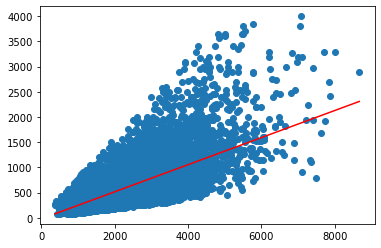

In [198]:
lr=LinearRegression()
lr.fit(df[['sqft_living']],df[target])
print(lr.coef_)
lr.score(df[['sqft_living']],df[target])
simple_test=[df[['sqft_living']].min(),df[['sqft_living']].max()]
simple_pred=lr.predict(simple_test)
fig,ax=plt.subplots()
ax.plot(simple_test,simple_pred,color='red')
ax.scatter(df['sqft_living'],df[target])

In [200]:
lr=LinearRegression()
lr.fit(cats_df[['x0_Spring','x0_Summer','x0_Winter']],cats_df[target])
lr.score(cats_df[['x0_Spring','x0_Summer','x0_Winter']],cats_df[target])

0.0011349020113433639

In [201]:
def forward_steps(data,Y,X):
    dependent=data[Y]
    Models=[[]]
    features=X.copy()
    lr=LinearRegression()
    def r_score_margin(original,new_f):
        X_Y=(data[original+[new_f]],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    while len(features)>0:
        M=Models[-1]
        new_f=max(features,key=lambda f: r_score_margin(M,f))
        features.remove(new_f)
        Models.append([new_f]+M)
    Models.remove([])
    return Models

def backward_steps(data,Y,X):
    dependent=data[Y]
    steps=len(X)
    Models=[X.copy()]
    lr=LinearRegression()
    def r_score_exmargin(original,new_f):
        ins=original.copy()
        ins.remove(new_f)
        X_Y=(data[ins],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    while steps>1:
        M=Models[-1].copy()
        worse_f=max(M,key=lambda f: r_score_exmargin(M,f))
        M.remove(worse_f)
        Models.append(M)
        steps-=1
    return Models

def subset_steps(data,Y,X):
    dimensions=X
    M=[]
    lr=LinearRegression()
    dependent=data[Y]
    def r_score_margin(inputs):
        X_Y=(data[inputs],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    for d in range(1,len(dimensions)+1):
        combos=[list(c) for c in combinations(dimensions,d)]
        top_model=max(combos,key=r_score_margin)
        M.append(top_model)
    return M

def CV_compare(data,Y,models,folds=5):
    scores={}
    lr=LinearRegression()
    state=random.randint(1,1000)
    SPLIT=KFold(folds,random_state=state,shuffle=True)
    for m in models:
        k='+'.join(m)
        scores[k]=cross_validate(lr,data[m],data[Y],cv=SPLIT)['test_score']
    return scores

In [241]:
fwd_models=forward_steps(df,target,dense_factors+sparse_factors+dummies)
fwd_models

[['sqft_living2'],
 ['grade', 'sqft_living2'],
 ['age', 'grade', 'sqft_living2'],
 ['x0_1.0', 'age', 'grade', 'sqft_living2'],
 ['view', 'x0_1.0', 'age', 'grade', 'sqft_living2'],
 ['bathrooms', 'view', 'x0_1.0', 'age', 'grade', 'sqft_living2'],
 ['bedrooms', 'bathrooms', 'view', 'x0_1.0', 'age', 'grade', 'sqft_living2'],
 ['sqft_outside15',
  'bedrooms',
  'bathrooms',
  'view',
  'x0_1.0',
  'age',
  'grade',
  'sqft_living2'],
 ['sqft_living15',
  'sqft_outside15',
  'bedrooms',
  'bathrooms',
  'view',
  'x0_1.0',
  'age',
  'grade',
  'sqft_living2'],
 ['condition',
  'sqft_living15',
  'sqft_outside15',
  'bedrooms',
  'bathrooms',
  'view',
  'x0_1.0',
  'age',
  'grade',
  'sqft_living2'],
 ['floors',
  'condition',
  'sqft_living15',
  'sqft_outside15',
  'bedrooms',
  'bathrooms',
  'view',
  'x0_1.0',
  'age',
  'grade',
  'sqft_living2'],
 ['sqft_living',
  'floors',
  'condition',
  'sqft_living15',
  'sqft_outside15',
  'bedrooms',
  'bathrooms',
  'view',
  'x0_1.0',
  '

In [242]:
CV_compare(df,target,fwd_models)

{'sqft_living2': array([0.51826849, 0.49186634, 0.50603984, 0.51586603, 0.50078919]),
 'grade+sqft_living2': array([0.57032772, 0.55127023, 0.55789486, 0.57176582, 0.56070435]),
 'age+grade+sqft_living2': array([0.63546859, 0.61584869, 0.62711272, 0.62803554, 0.62763653]),
 'x0_1.0+age+grade+sqft_living2': array([0.66994378, 0.63615658, 0.65713   , 0.64866203, 0.64739346]),
 'view+x0_1.0+age+grade+sqft_living2': array([0.67606316, 0.64588185, 0.66459302, 0.65881739, 0.65622141]),
 'bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.68050672, 0.65140597, 0.66816789, 0.66317222, 0.65788108]),
 'bedrooms+bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.68326625, 0.65339052, 0.67048967, 0.66569096, 0.66076135]),
 'sqft_outside15+bedrooms+bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.684921  , 0.65437432, 0.67189123, 0.66793392, 0.66338967]),
 'sqft_living15+sqft_outside15+bedrooms+bathrooms+view+x0_1.0+age+grade+sqft_living2': array([0.68580241, 0.65597469, 0.67561179

In [243]:
back_models=backward_steps(df,target,dense_factors+sparse_factors+dummies)
back_models

[['sqft_living',
  'sqft_outside',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_Summer',
  'x0_Winter',
  'x0_1.0'],
 ['sqft_living',
  'sqft_outside',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_Summer',
  'x0_1.0'],
 ['sqft_living',
  'sqft_outside',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_1.0'],
 ['sqft_living',
  'percent_above',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_living2',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'sqft_

In [245]:
CV_compare(df,target,back_models)

{'sqft_living+sqft_outside+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_Summer+x0_Winter+x0_1.0': array([0.69354155, 0.66660261, 0.66535827, 0.68151024, 0.67567623]),
 'sqft_living+sqft_outside+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_Summer+x0_1.0': array([0.69354712, 0.66660004, 0.66544813, 0.68173626, 0.67571009]),
 'sqft_living+sqft_outside+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_1.0': array([0.69350706, 0.66690401, 0.66544534, 0.68170319, 0.67569906]),
 'sqft_living+percent_above+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grade+condition+x0_Spring+x0_1.0': array([0.69349928, 0.66672203, 0.66584568, 0.68163829, 0.67552339]),
 'sqft_living+sqft_living15+sqft_outside15+age+sqft_living2+bedrooms+bathrooms+floors+view+grad

In [206]:
sub_models=subset_steps(df,target,dense_factors+sparse_factors+dummies)
sub_models

[['sqft_living'],
 ['age', 'grade'],
 ['sqft_living', 'age', 'grade'],
 ['sqft_living', 'age', 'grade', 'x0_1.0'],
 ['sqft_living', 'age', 'view', 'grade', 'x0_1.0'],
 ['sqft_living', 'age', 'bathrooms', 'view', 'grade', 'x0_1.0'],
 ['sqft_living', 'age', 'bedrooms', 'bathrooms', 'view', 'grade', 'x0_1.0'],
 ['sqft_living',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'view',
  'grade',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'view',
  'grade',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'view',
  'grade',
  'condition',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_1.0'],
 ['sqft_living',
  'sqft_living15',
  'sqft_outside15',
  'age',
  'bedrooms',
  'bathrooms',
  'floors',
  'view',
  'grade',
  'condition',
  'x0_Spring',

In [207]:
CV_compare(cats_df,target,sub_models)

{'sqft_living': array([0.48954724, 0.47173606, 0.48637814, 0.4781497 , 0.48278568]),
 'age+grade': array([0.52398103, 0.5426704 , 0.52195019, 0.54760279, 0.54468306]),
 'sqft_living+age+grade': array([0.60480582, 0.60444763, 0.60416392, 0.60982412, 0.61077437]),
 'sqft_living+age+grade+x0_1.0': array([0.63270856, 0.62171146, 0.63447014, 0.64173792, 0.63797311]),
 'sqft_living+age+view+grade+x0_1.0': array([0.64277672, 0.63442934, 0.64245736, 0.64913536, 0.64786991]),
 'sqft_living+age+bathrooms+view+grade+x0_1.0': array([0.64434606, 0.63795305, 0.64658952, 0.65313416, 0.65085219]),
 'sqft_living+age+bedrooms+bathrooms+view+grade+x0_1.0': array([0.64803539, 0.64182682, 0.65259991, 0.65780512, 0.65675365]),
 'sqft_living+sqft_outside15+age+bedrooms+bathrooms+view+grade+x0_1.0': array([0.65002848, 0.64362097, 0.65392065, 0.65825334, 0.65919659]),
 'sqft_living+sqft_living15+sqft_outside15+age+bedrooms+bathrooms+view+grade+x0_1.0': array([0.65195397, 0.64332645, 0.65682229, 0.65970873, 0.6

In [238]:
pf=PolynomialFeatures(2)
X=pd.DataFrame(pf.fit_transform(df[['sqft_living']]),columns=pf.get_feature_names()).drop('1',axis=1)
X

x0       x0^2
0      1180.0  1392400.0
1      2570.0  6604900.0
2       770.0   592900.0
3      1960.0  3841600.0
4      1680.0  2822400.0
...       ...        ...
21462  1530.0  2340900.0
21463  2310.0  5336100.0
21464  1020.0  1040400.0
21465  1600.0  2560000.0
21466  1020.0  1040400.0

[21467 rows x 2 columns]

In [235]:
lr=LinearRegression()
lr.fit(X,df[target])
lr.score(X,df[target])

0.5091582236646464

In [219]:
pf.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [ ]:
df['sqft_living'].values.reshape(-1,1)